In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/swaillidataset/SampleSubmission.csv
/kaggle/input/swaillidataset/Train.csv
/kaggle/input/swaillidataset/VariableDefinitions.csv
/kaggle/input/swaillidataset/Test.csv


In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import log_loss, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize 

import re
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load the training data
train_data = pd.read_csv('/kaggle/input/swaillidataset/Train.csv')
test_data =  pd.read_csv('/kaggle/input/swaillidataset/Test.csv')



In [4]:
train_data.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [5]:
test_data.head()

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


In [7]:
train_data['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)

In [8]:
train_data.shape

(5151, 3)

In [9]:
train_data.dtypes

id          object
content     object
category    object
dtype: object

In [10]:
train_data.isnull().any()

id          False
content     False
category    False
dtype: bool

<Axes: xlabel='category', ylabel='count'>

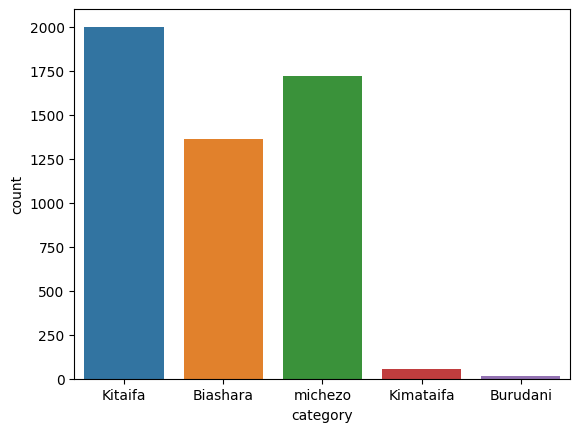

In [4]:
# Convert to categorical type
train_data['category'] = train_data['category'].astype(str)  # or .astype('category')

# Plot the countplot
sns.countplot(x=train_data['category'])

In [5]:
train_data['News_length'] = train_data['content'].str.len()
print(train_data['News_length'])

0       1584
1       1317
2       2610
3       1404
4       2247
        ... 
5146    6742
5147    2348
5148    3014
5149    1216
5150    1889
Name: News_length, Length: 5151, dtype: int64


In [6]:
train_data['content']=train_data['content'].str.lower()
train_data['content']=train_data['content'].str.replace("[^a-zA-Z]"," ") # removes everyting except alphabet (small and caps)



In [7]:
# Tokenization
import nltk
nltk.download('punkt')
word=[]
for i in train_data['content']: # loops over the content
    word.append(word_tokenize(i))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# creating swahili stopwords list
filter_sent=[]
stopwords_swahili=["akasema","alikuwa","amesema","alisema","ambayo","ambapo","ambao","baada","basi","bila","cha","chini","hadi","hapo","hata",
                   "hivyo","hiyo","huku","huo","ili","ilikuwa","juu","kama","karibu","katika","kila",
                   "kima","kisha","kubwa","kutoka","kutokana","kwani","kuwa","kwa","kwamba","kwenda","kwenye","la",
                   "lakini","mara","mdogo","mimi","mkubwa","mmoja","moja","muda","mwenye","na",
                   "naye","ndani","ng","ni","nini","nonkungu","pamoja","pia","sana","sasa","sauti",
                   "tafadhali","tena","tu","vile","wa","wakati","wake","walikuwa","wao","watu","wengine",
                   "wote","ya","yake","yangu","yao","yeye","yule","za","zaidi","zake"]
for i in word:
    l=[]
    for j in i:
        if j not in stopwords_swahili:
            l.append(j) # This method appends an element to the end of the list
    filter_sent.append(' '.join(l))

In [9]:
train_data['content']=filter_sent

In [18]:
train_data.tail()

,id,content,category,News_length
5146,SW993,rais john magufuli ameendelea kung ’ ara siasa...,Kitaifa,6742
5147,SW994,kampeni inayohimiza watafi ti kuandika upya hi...,Kitaifa,2348
5148,SW996,"matukio mapya malaria 1,000 jamii , yamepungua...",Kitaifa,3014
5149,SW997,imeelezwa hakuna sheria yoyote inayokataza taa...,Kitaifa,1216
5150,SW999,akizungumza kutiwa saini makubaliano hayo jana...,Biashara,1889


In [10]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
train_data['category1']= label_encoder.fit_transform(train_data['category']) 
train_data.head()

,id,content,category,News_length,category1
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa,1584,3
1,SW1,"mkuu mkoa tabora , aggrey mwanri amesitisha li...",Biashara,1317,0
2,SW10,serikali imetoa miezi sita taasisi zote umma a...,Kitaifa,2610,3
3,SW100,kampuni mchezo kubahatisha m-bet imeingia maku...,michezo,1404,4
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu ...,Kitaifa,2247,3


In [11]:
# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['content'], train_data['category1'], test_size=0.2, random_state=42
)

In [12]:
# Step 2: Load the pre-trained AfriBERTa model and tokenizer
model_name = "castorini/afriberta_large"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
val_encodings = tokenize_function(val_texts.tolist())

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels.tolist()
})



config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [23]:
train_data

,id,content,category,News_length,category1
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa,1584,3
1,SW1,"mkuu mkoa tabora , aggrey mwanri amesitisha li...",Biashara,1317,0
2,SW10,serikali imetoa miezi sita taasisi zote umma a...,Kitaifa,2610,3
3,SW100,kampuni mchezo kubahatisha m-bet imeingia maku...,michezo,1404,4
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu ...,Kitaifa,2247,3
...,...,...,...,...,...
5146,SW993,rais john magufuli ameendelea kung ’ ara siasa...,Kitaifa,6742,3
5147,SW994,kampeni inayohimiza watafi ti kuandika upya hi...,Kitaifa,2348,3
5148,SW996,"matukio mapya malaria 1,000 jamii , yamepungua...",Kitaifa,3014,3
5149,SW997,imeelezwa hakuna sheria yoyote inayokataza taa...,Kitaifa,1216,3


In [13]:
from transformers import EarlyStoppingCallback
# Step 3: Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Increase batch size if GPU memory allows
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # Reduce epochs for faster training
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Enable mixed precision training (requires GPU)
    gradient_accumulation_steps=2,  # Simulate larger batch sizes
    dataloader_num_workers=4,# Use multiple workers for data loading
    report_to = "none",
)

# Step 4: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



In [14]:
from transformers import GenerationConfig

# Update model generation config to avoid the warning
model.generation_config = GenerationConfig(max_length=512)

# Train the model
trainer.train()



Epoch,Training Loss,Validation Loss
1,0.492600,0.416055
2,0.396800,0.362314
3,0.321500,0.292595
4,0.285100,0.278000
5,0.229100,0.304057
6,0.208600,0.273451
7,0.161300,0.284056
8,0.142000,0.287120
9,0.118600,0.293697


TrainOutput(global_step=297, training_loss=0.2818478863648694, metrics={'train_runtime': 1676.2856, 'train_samples_per_second': 24.578, 'train_steps_per_second': 0.191, 'total_flos': 8141665125703680.0, 'train_loss': 0.2818478863648694, 'epoch': 9.0})

In [15]:
# Step 5: Evaluate the model
val_predictions = trainer.predict(val_dataset)
val_pred_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=1).numpy()



In [16]:
# Calculate Log Loss
val_true_labels = val_dataset['labels']
logloss = log_loss(val_true_labels, val_pred_probs, labels=range(len(label_encoder.classes_)))
print(f"Validation Log Loss: {logloss}")



Validation Log Loss: 0.27343991927011413


In [17]:
# Classification Report
val_pred_labels = val_pred_probs.argmax(axis=1)
report = classification_report(val_true_labels, val_pred_labels, target_names=label_encoder.classes_, output_dict=True)
print("Classification Report:")
print(pd.DataFrame(report).T)



Classification Report:
              precision    recall  f1-score      support
Biashara       0.868327  0.897059  0.882459   272.000000
Burudani       0.000000  0.000000  0.000000     2.000000
Kimataifa      0.750000  0.666667  0.705882     9.000000
Kitaifa        0.912568  0.869792  0.890667   384.000000
michezo        0.952128  0.983516  0.967568   364.000000
accuracy       0.913676  0.913676  0.913676     0.913676
macro avg      0.696605  0.683407  0.689315  1031.000000
weighted avg   0.911674  0.913676  0.912311  1031.000000


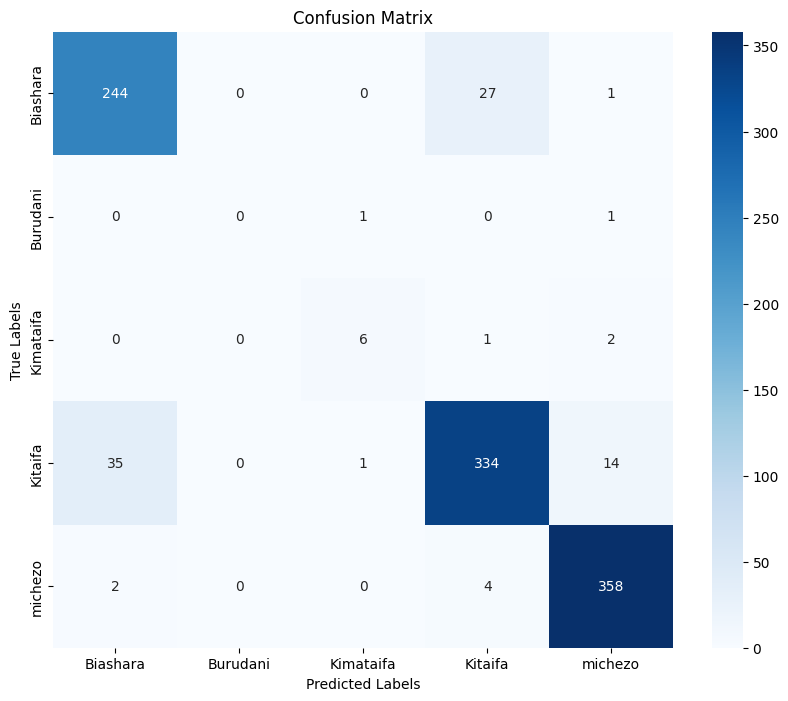

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [19]:
# Step 6: Load the test data
test_data = pd.read_csv('/kaggle/input/swaillidataset/Test.csv')  # Replace with your test file
test_data['News_length'] = train_data['content'].str.len()
print(test_data['News_length'])


0       1325
1       1141
2       2044
3       1116
4       1815
        ... 
1283     446
1284    1314
1285    1112
1286    1912
1287    1663
Name: News_length, Length: 1288, dtype: int64


In [20]:
test_data['content']=test_data['content'].str.lower()
test_data['content']=test_data['content'].str.replace("[^a-zA-Z]"," ") # removes everyting except alphabet (small and caps)



In [21]:
# Tokenization
import nltk
nltk.download('punkt')
word=[]
for i in test_data['content']: # loops over the content
    word.append(word_tokenize(i))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# creating swahili stopwords list
filter_sent=[]
stopwords_swahili=["akasema","alikuwa","amesema","alisema","ambayo","ambapo","ambao","baada","basi","bila","cha","chini","hadi","hapo","hata",
                   "hivyo","hiyo","huku","huo","ili","ilikuwa","juu","kama","karibu","katika","kila",
                   "kima","kisha","kubwa","kutoka","kutokana","kwani","kuwa","kwa","kwamba","kwenda","kwenye","la",
                   "lakini","mara","mdogo","mimi","mkubwa","mmoja","moja","muda","mwenye","na",
                   "naye","ndani","ng","ni","nini","nonkungu","pamoja","pia","sana","sasa","sauti",
                   "tafadhali","tena","tu","vile","wa","wakati","wake","walikuwa","wao","watu","wengine",
                   "wote","ya","yake","yangu","yao","yeye","yule","za","zaidi","zake"]
for i in word:
    l=[]
    for j in i:
        if j not in stopwords_swahili:
            l.append(j) # This method appends an element to the end of the list
    filter_sent.append(' '.join(l))

In [23]:
test_data['content']=filter_sent

In [45]:
test_data

,swahili_id,content,News_length
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"mkuu wilaya bahi , mkoani dodoma , mwanahamisi...",1325
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"mwishoni mwa wiki hii , timu soka taifa , taif...",1141
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,thamani mauzo bidhaa afrika mashariki umoja ul...,2044
3,00868eeee349e286303706ef0ffd851f39708d37,meneja mawasiliano utetezi asasi agpahi amefar...,1116
4,00a5cb12d3058dcf2e42f277eee599992db32412,"waziri kilimo , japhet hasunga serikali inajen...",1815
...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,mkurugenzi msaidizi msajili asasi kirai idara ...,446
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,kilomoni jana kesho atazungumzia suala hilo ku...,1314
1285,feed09e13586d12139cd59bc20996a4d29706606,"timu taifa soka tanzania bara , kilimanjaro st...",1112
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"yanga imetozwa faini sh 3,500,000 makosa mawil...",1912


In [24]:
test_encodings = tokenize_function(test_data['content'].tolist())

In [25]:
# Create a Dataset for prediction
test_dataset_pred = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

In [26]:
# Get predictions
predictions = trainer.predict(test_dataset_pred)
predicted_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()



In [27]:
# Convert probabilities to predicted labels
test_pred_labels = predicted_probs.argmax(axis=1)

In [28]:
print(test_pred_labels)
test_pred_labels.shape

[3 4 0 ... 4 4 3]


(1288,)

In [54]:
test_data['predicted label'] = test_pred_labels


In [55]:
test_data

,swahili_id,content,News_length,label,predicted label
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"mkuu wilaya bahi , mkoani dodoma , mwanahamisi...",1325,3,3
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"mwishoni mwa wiki hii , timu soka taifa , taif...",1141,4,4
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,thamani mauzo bidhaa afrika mashariki umoja ul...,2044,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,meneja mawasiliano utetezi asasi agpahi amefar...,1116,3,3
4,00a5cb12d3058dcf2e42f277eee599992db32412,"waziri kilimo , japhet hasunga serikali inajen...",1815,3,3
...,...,...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,mkurugenzi msaidizi msajili asasi kirai idara ...,446,3,3
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,kilomoni jana kesho atazungumzia suala hilo ku...,1314,4,4
1285,feed09e13586d12139cd59bc20996a4d29706606,"timu taifa soka tanzania bara , kilimanjaro st...",1112,4,4
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"yanga imetozwa faini sh 3,500,000 makosa mawil...",1912,4,4


In [56]:
output_path = "/kaggle/working/output2_file.csv"
test_data.to_csv(output_path, index=False)

In [34]:
from transformers import GenerationConfig

# Update model generation config to avoid the warning
model.generation_config = GenerationConfig(max_length=512)

# Save the model and tokenizer for future inference
model.save_pretrained("./afriberta-swahili")
tokenizer.save_pretrained("./afriberta-swahili")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


('./afriberta-swahili/tokenizer_config.json',
 './afriberta-swahili/special_tokens_map.json',
 './afriberta-swahili/sentencepiece.bpe.model',
 './afriberta-swahili/added_tokens.json')

In [29]:
# Inference: Load and use the trained model
def predict(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.argmax(dim=-1).tolist()

In [30]:
import torch

# Detect the available device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

def predict(texts):
    # Tokenize and move inputs to the same device as the model
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU/CPU

    # Perform inference
    with torch.no_grad():  # Disable gradient calculations for efficiency
        outputs = model(**inputs)

    # Convert logits to probabilities and get predictions
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.argmax(dim=-1).tolist()

# Example usage
test_sentences = ["Bei ya Mafuta Yapanda kwa Asilimia 10, Wananchi Watoa Maoni Mseto", "Msanii Maarufu Azindua Albamu Mpya kwa Tamasha Kubwa"]
predictions = predict(test_sentences)
print(predictions)


[0, 4]
